In [ ]:
!pip install snntorch

In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "./drive/MyDrive/Colab Notebooks/NumtaDB - Bengali Handwritten Digits/NumtaDB - Bengali Handwritten Digits.zip" -d "/content"

In [5]:
set_ids = ('a', 'b', 'c', 'd', 'e')
csv_data_all = []
for id in set_ids:
  csv_file = pd.read_csv('./training-' + id + '.csv')
  csv_data = csv_file[['filename', 'digit']]
  csv_data_all.append(csv_data)

In [6]:
csv_data = csv_data_all[0]
csv_data.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [7]:
image_size = 32

In [8]:
class Dataset_(Dataset):
  def __init__(self, df, root, transform=None, invert=True, dilate=True):
    self.data = df
    self.root = root
    self.transform = transform
    self.invert = invert
    self.dilate = dilate
      
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    item = self.data.iloc[index]
    
    path = self.root + "/" + item[0]
    # image = Image.open(path).convert('L')
    image_gray = cv2.imread(path, 0)
    if self.invert:
      image_mnist_format = 255 - image_gray
    else:
      image_mnist_format = image_gray
    
    if self.dilate:
      dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
      dilate = cv2.dilate(image_mnist_format, dilate_kernel, iterations=3)

    resized_gray = cv2.resize(image_mnist_format, (image_size, image_size), interpolation = cv2.INTER_AREA)

    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(resized_gray, -1, kernel)

    # image = cv2.fastNlMeansDenoising(sharpen)
    # #Gaussian Blur
    # gaussian_3 = cv2.GaussianBlur(image, (9,9), 10.0) #unblur
    # image = cv2.addWeighted(image, 1.5, gaussian_3, -0.5, 0, image)
    
    _, thresholded = cv2.threshold(sharpen, 130, 255, cv2.THRESH_BINARY)
    label = item[1]

    
    if self.transform is not None:
      image = self.transform(thresholded)
        
    return image, label 

In [9]:
from torchvision.transforms.transforms import ToPILImage
mean = (0,)
std = (1,)


train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),])

# Create datasets and merge them all
datasets = []
for i in range(len(set_ids)):
  if set_ids[i] == 'e':
    dataset = Dataset_(csv_data_all[i], 'training-'+set_ids[i], test_transform, invert=False, dilate=False)
  else:
    dataset = Dataset_(csv_data_all[i], 'training-'+set_ids[i], test_transform)
  datasets.append(dataset)

train_dataset = ConcatDataset(datasets)

datasets = []
for i in range(len(set_ids)):
  if set_ids[i] == 'e':
    dataset = Dataset_(csv_data_all[i], 'training-'+set_ids[i], test_transform, invert=False, dilate=False)
  else:
    dataset = Dataset_(csv_data_all[i], 'training-'+set_ids[i], test_transform)
  datasets.append(dataset)

test_dataset = ConcatDataset(datasets)
print("Trainig Samples: ",len(train_dataset))

Trainig Samples:  72045


14739


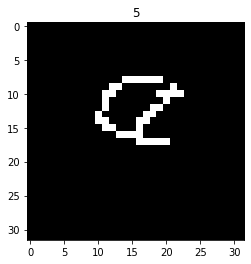

In [10]:
index = np.random.randint(len(train_dataset))
print(index)
plt.imshow(train_dataset[index][0][0], cmap='gray')
plt.title(train_dataset[index][1])
plt.show()

In [11]:
# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_dataset)

# mix data
# index of num of train
indices = list(range(num_train))

# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))

# divied into two part
train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

print("Train Samples: ",len(train_idx))
print("Test Samples: ",len(test_idx))

Train Samples:  64841
Test Samples:  7204


In [12]:
'''
MAKING DATASET ITERABLE
'''
BATCH_SIZE = 220

# prepare loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, drop_last=True)

print("Train dataloader: {}".format(len(train_loader)))
print("Test dataloader: {}".format(len(test_loader)))

Train dataloader: 294
Test dataloader: 32


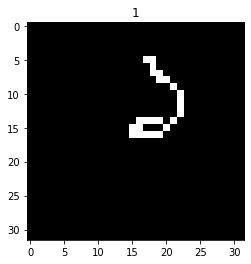

In [13]:
for i, (images, labels) in enumerate(train_loader):
  plt.imshow(images[2].view(image_size, image_size), cmap='gray')
  plt.title(labels[2].item())
  plt.show()
  break

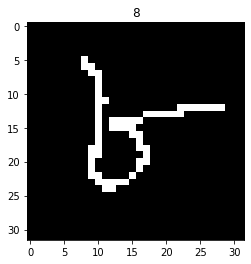

In [14]:
for i, (images, labels) in enumerate(test_loader):
  index = np.random.randint(100)
  plt.imshow(images[index].view(image_size, image_size), cmap='gray')
  plt.title(labels[index].item())
  plt.show()
  break

In [19]:
# Defining the network
num_inputs = image_size*image_size
num_hidden = 8000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.97

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    
    # Layers
    self.fc1 = nn.Linear(num_inputs, num_hidden)
    self.lif1 = snn.Leaky(beta=beta)
    self.fc2 = nn.Linear(num_hidden, num_outputs)
    self.lif2 = snn.Leaky(beta=beta)
    
  def forward(self, X):
      
    # Initialize the hidden state at t=0
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()
    
    # Record the final layer
    spk2_rec = []
    mem2_rec = []
    
    for step in range(num_steps):
      cur1 = self.fc1(X)
      spk1, mem1 = self.lif1(cur1, mem1)
      cur2 = self.fc2(spk1)
      spk2, mem2 = self.lif2(cur2, mem2)
      spk2_rec.append(spk2)
      mem2_rec.append(mem2)
        
    return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [21]:
# Building the model
model = Model()
CUDA = torch.cuda.is_available()
print("GPU Enabled?:", CUDA)
if CUDA:
  model = model.cuda()
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2)

GPU Enabled?: True


In [22]:
train_losses = []
train_accuracys = []

In [23]:
num_epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
  # Training
  epoch_correct_images = 0
  epoch_loss = 0
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    if CUDA:
      images = images.cuda()
      labels = labels.cuda()
    output, mem_rec = model(images.view(BATCH_SIZE, -1)) # output shape: num_steps*batch_size*num_classes\
    _, predictions = output.sum(dim=0).max(1) # summing across all time steps and taking maximum across num_classes
    correct_images = (predictions == labels).sum().item()
    epoch_correct_images += correct_images
    
    # We have to sum up loss for all time steps
    loss = torch.zeros((1), dtype=torch.float)
    if CUDA:
      loss = loss.cuda()
    for step in range(num_steps):
      loss += loss_fn(mem_rec[step], labels)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
    train_loss.append(loss.item())
    train_accuracy.append(correct_images/BATCH_SIZE*100.0)
    epoch_loss += loss.item()
    
    if (i+1)%8 == 0:
      print(f"Train iteration: {i+1}/{len(train_loader)} | Loss: {loss.item():.2f}, Accuracy: {correct_images/len(images)*100.0:.2f}%")
  
  # train_loss.append(epoch_loss/len(train_loader))
  # train_accuracy.append(epoch_correct_images/(len(train_loader)*BATCH_SIZE))
  
  # Testing
  epoch_correct_images = 0
  epoch_loss = 0
  model.eval()
  with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      if CUDA:
        images = images.cuda()
        labels = labels.cuda()
      output, mem_rec = model(images.view(BATCH_SIZE, -1)) # output shape: num_steps*batch_size*num_classes
      _, predictions = output.sum(dim=0).max(1) # summing across all time steps and taking maximum across num_classes
      correct_images = (predictions == labels).sum().item()
      epoch_correct_images += correct_images

      # We have to sum up loss for all time steps
      loss = torch.zeros((1), dtype=torch.float)
      if CUDA:
        loss = loss.cuda()
      for step in range(num_steps):
        loss += loss_fn(mem_rec[step], labels)
      
      test_loss.append(loss.item())
      test_accuracy.append(correct_images/BATCH_SIZE*100.0)
      epoch_loss += loss.item()
      if (i+1)%8 == 0:
        print(f"Test iteration: {i+1}/{len(test_loader)} | Loss: {loss.item():.2f}, Accuracy: {correct_images/len(images)*100.0:.2f}%")
  
    # test_loss.append(epoch_loss/len(test_loader))
    # test_accuracy.append(epoch_correct_images/(len(test_loader)*BATCH_SIZE))
  
  # Printing Statistics
  print(f"Epoch: {epoch+1}/{num_epochs} | Train_loss: {train_loss[-1]:.2f}, Train_accuracy: {train_accuracy[-1]:.2f}% | \
Test_loss: {test_loss[-1]:.2f}, Test_accuracy: {test_accuracy[-1]:.2f}%")

Train iteration: 8/294 | Loss: 49.51, Accuracy: 32.27%
Train iteration: 16/294 | Loss: 46.05, Accuracy: 40.91%
Train iteration: 24/294 | Loss: 49.18, Accuracy: 43.64%
Train iteration: 32/294 | Loss: 45.37, Accuracy: 50.45%
Train iteration: 40/294 | Loss: 46.47, Accuracy: 48.64%
Train iteration: 48/294 | Loss: 44.43, Accuracy: 45.45%
Train iteration: 56/294 | Loss: 42.29, Accuracy: 58.18%
Train iteration: 64/294 | Loss: 43.27, Accuracy: 49.55%
Train iteration: 72/294 | Loss: 41.14, Accuracy: 56.82%
Train iteration: 80/294 | Loss: 38.80, Accuracy: 54.09%
Train iteration: 88/294 | Loss: 40.22, Accuracy: 53.64%
Train iteration: 96/294 | Loss: 36.71, Accuracy: 60.91%
Train iteration: 104/294 | Loss: 34.56, Accuracy: 60.00%
Train iteration: 112/294 | Loss: 33.37, Accuracy: 62.27%
Train iteration: 120/294 | Loss: 29.90, Accuracy: 64.09%
Train iteration: 128/294 | Loss: 27.89, Accuracy: 70.45%
Train iteration: 136/294 | Loss: 27.17, Accuracy: 70.00%
Train iteration: 144/294 | Loss: 30.62, Accu

In [ ]:
train_losses.append(train_loss)
train_accuracys.append(train_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for images, labels in train_loader:
  if CUDA:
    images = images.cuda()
    labels = labels.cuda()
  output, mem_rec = model(images.view(BATCH_SIZE, -1)) # output shape: num_steps*batch_size*num_classes
  _, predictions = output.sum(dim=0).max(1) # summing across all time steps and taking maximum across num_classes

  # output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
  y_pred.extend(predictions.cpu().numpy()) # Save Prediction
  
  # labels = labels.data.cpu().numpy()
  labels = labels.cpu().numpy()
  y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', '2', '3', '4', '5',
        '6', '7', '8', '9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
len(train_losses), len(train_accuracys)

In [ ]:
train_accuracys

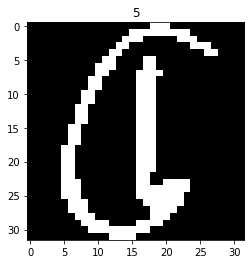

In [ ]:
for images, labels in test_loader:
  index = np.random.randint(100)
  image_ori = images[index]
  image = image_ori.view(1, -1).cuda() # Adding batch size of 1
  output, _ = model(image)
  _, prediction = output.sum(dim=0).max(1)
  plt.imshow(image_ori.view(image_size, image_size), cmap='gray')
  plt.title(prediction.item())
  plt.show()
  break

In [ ]:
len(train_accuracys[0])

In [ ]:
def smoother(losses, adjust):
  values = []
  avg_value = 0
  for loss in losses:
    avg_value = avg_value*0.95 + loss*0.05
    values.append(avg_value+adjust)
  
  return values

In [ ]:
start_index = 60
last_index = -1
new_list = [smoother(train_losses[0], 0)[start_index:last_index], smoother(train_losses[1], 0)[start_index:last_index], smoother(train_losses[2], 0)[start_index:last_index]]

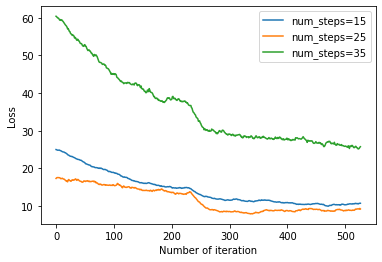

In [ ]:
plt.plot(new_list[0], label='num_steps=15')
plt.plot(new_list[1], label='num_steps=25')
plt.plot(new_list[2], label='num_steps=35')
plt.legend()
plt.xlabel('Number of iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
import pickle
with open('snn_losses_num_steps.pkl', 'wb') as f:
  pickle.dump(train_losses, f)

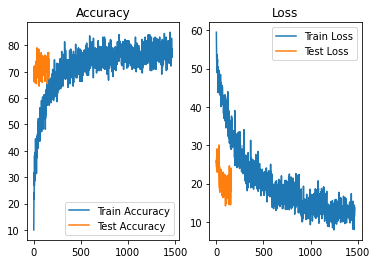

In [ ]:
# Visualizing the loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_accuracy, label='Train Accuracy')
ax1.plot(test_accuracy, label='Test Accuracy')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(train_loss, label='Train Loss')
ax2.plot(test_loss, label='Test Loss')
ax2.set_title('Loss')
ax2.legend()

plt.show()